# feature extraction for logistic CVD models
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import seaborn as sns
import scipy

### Loading predictions

In [6]:
# def get_output_maps_for_ds(output_maps_dir, ids):
#     output_maps_lists = defaultdict(lambda : [])
#     key_order = None
#     for ID in tqdm(ids, position=0, leave=True):
#         output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
#         key_order = natsorted(list(output_maps_data.keys()))
#         for output_type in key_order:
#             output_maps_lists[ID].append(torch.from_numpy(output_maps_data[output_type]))
            
#     return output_maps_lists, key_order
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True):
        # print(fID)
        # break
        if ".npz" in fID:
            ID = fID.split(".")[0]
            output_maps_data = np.load(output_maps_dir+fID)
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [7]:
# model_name = "SSN_Ens_Mean"
model_name = "SSN_Ens"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{model_name}/"
output_maps_for_umaps, key_order = load_output_maps(output_maps_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:59<00:00,  4.23it/s]


In [8]:
model_name_for_pred = "SSN_Ens_Mean"
output_maps_dir_for_pred = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{model_name_for_pred}/"
output_maps_for_pred, key_order_for_pred = load_output_maps(output_maps_dir_for_pred)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:57<00:00,  4.34it/s]


In [9]:
key_order

['ent', 'pred', 'seg', 'var']

In [10]:
ID = list(output_maps_for_umaps.keys())[2]

In [11]:
img_us = output_maps_for_umaps[ID]
img_ps = output_maps_for_pred[ID]

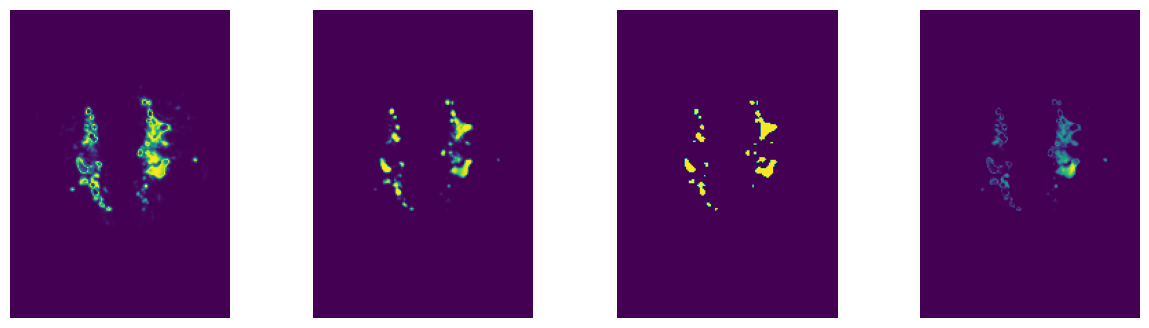

In [12]:
plt.figure(figsize=(15,4))
islice = 31
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(img_us[i][islice])
    plt.axis('off')

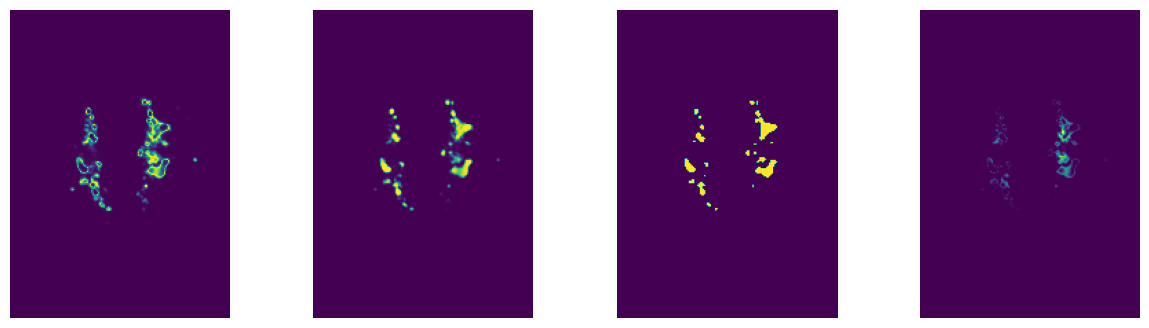

In [13]:
ent, pred, seg, var = img_ps
plt.figure(figsize=(15,4))
islice = 31
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(img_ps[i][islice])
    plt.axis('off')

In [14]:
t = 0.1
ent_voxels = ent[ent > t]
pred_voxels = pred[pred > t]
var_voxels = var[var > t/10]

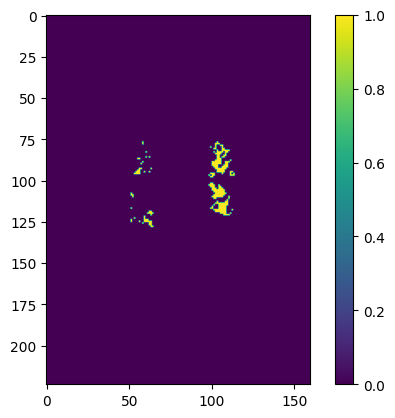

In [15]:
plt.imshow(var[islice]>0.01)
plt.colorbar()

<AxesSubplot: ylabel='Density'>

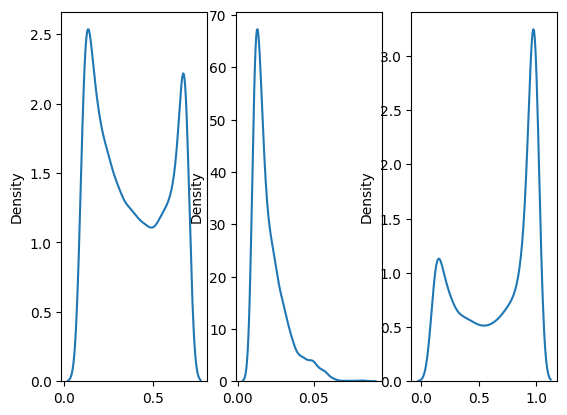

In [16]:
plt.subplot(1,3,1)
sns.kdeplot(ent_voxels)
plt.subplot(1,3,2)
sns.kdeplot(var_voxels)
plt.subplot(1,3,3)
sns.kdeplot(pred_voxels)

In [17]:
def histogram_distribution(values, bins=20, minv=None, maxv=None):
    # so that the output values are meaningful, I need to carefully set the min a max. mnin should be t, and max should be the max across all the data I think.
    if minv == None:
        minv = values.min()
    if maxv == None:
        maxv = values.max()
    counts = torch.zeros(bins)
    bounds = torch.arange(minv,maxv, (maxv-minv)/bins)
    for i, (lower_bound, upper_bound) in enumerate(zip(bounds[:-1], bounds[1:])):
        counts[i] = ((values >= lower_bound) * (values < upper_bound)).sum()

    Z = counts.sum()
    counts = counts / Z
    return counts

In [18]:
def gaussian_summary_statistics(values):
    sum = values.sum().item()
    mean = values.mean().item()
    std = values.std().item()
    skew = scipy.stats.skew(values)
    kurtosis = scipy.stats.kurtosis(values, fisher=False)
    return sum, mean, std, skew, kurtosis

In [19]:
histogram_distribution(ent_voxels, 20)

tensor([0.0978, 0.0785, 0.0622, 0.0546, 0.0506, 0.0463, 0.0434, 0.0406, 0.0364,
        0.0376, 0.0352, 0.0332, 0.0335, 0.0320, 0.0338, 0.0367, 0.0375, 0.0425,
        0.0505, 0.1170])

In [20]:
# counts, counts.sum()

<AxesSubplot: ylabel='Count'>

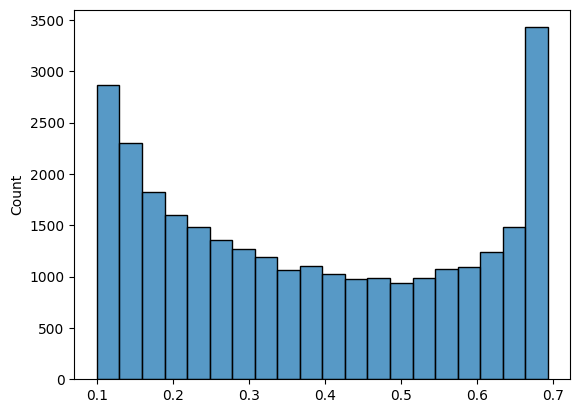

In [21]:
sns.histplot(ent_voxels, bins=20)

### overlap proportions computation
- [x] proportion of segmented area that is uncertain
- [x] proportion of uncertain area that is segmented
- [x] proportion of uncertain area that is within segmentation + edge expansion

In [22]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

### loading the ventricles for ventricle distance analysis

In [23]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as tv

# resamples an image
def get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1., 1., 3.], is_label=False):
    
    if not original_spacing:
        # orig spacing can be specified when the input itk_image does not know its actual spacing.
        original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)
      
def resample_and_return(filename_in, is_label=False, out_spacing=[1., 1., 3.], original_spacing=None):
    """
    resamples an image to custom voxel dimensions and returns image as a numpy array
    
    filename_in: .nii.gz file to load
    is_label: is the file a brain scan or a segmentaion mask
    outspacing: the spacing of the image to be resampled to.
    """
        
    # resample the image
    image = sitk.ReadImage(filename_in)
    resampled_image = get_resampled_img(image, out_spacing=out_spacing, original_spacing=original_spacing, is_label=is_label)
    
    return sitk.GetArrayFromImage(resampled_image)

In [24]:
# this loop takes a while as its loading from disk and resampling
# it takes around 11 minutes

cropper = tv.transforms.CenterCrop((224, 160))

def load_fast_output(file, slices):
    timg = resample_and_return(file, is_label=True)
        
    # interpolate the channel number and centre crop
    timg = torch.Tensor(timg)
    timg = torch.nn.functional.interpolate(timg.unsqueeze(0).unsqueeze(0), (slices, *timg.shape[1:])).squeeze()
    timg = cropper(timg.view((1, 1, *timg.shape))).squeeze()
    
    return timg



In [25]:
IDs_outmaps = natsorted(list(output_maps_for_umaps.keys()))
IDs = [("_".join(idx.split("_")[:-2]), idx) for idx in IDs_outmaps if "out_maps" in idx]

In [26]:
IDs_outmaps[0:5], IDs[0:5]

(['CVD001_out_maps',
  'CVD002_out_maps',
  'CVD003_out_maps',
  'CVD004_out_maps',
  'CVD008_out_maps'],
 [('CVD001', 'CVD001_out_maps'),
  ('CVD002', 'CVD002_out_maps'),
  ('CVD003', 'CVD003_out_maps'),
  ('CVD004', 'CVD004_out_maps'),
  ('CVD008', 'CVD008_out_maps')])

In [27]:
output_maps_for_umaps[IDs[0][1]][0].shape

torch.Size([48, 224, 160])

In [28]:
vent_folder = "/home/s2208943/ipdis/data/preprocessed_data/EdData_ventmapper/"
vent_filenames = os.listdir(vent_folder)
ID_ventpath_map = {"_".join(f.split("_")[:-1]): vent_folder + f for f in vent_filenames}
vent_maps = []
for i in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[i]
    num_slices = output_maps_for_umaps[ID[1]][0].shape[0]
    vent_path = ID_ventpath_map[ID[0]]
    vent_seg = load_fast_output(vent_path, num_slices)
    vent_maps.append(vent_seg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:38<00:00,  6.57it/s]


In [29]:
vent_maps[0].shape, vent_maps[0].sum(dim=(1,2,)).argmax(0)

(torch.Size([48, 224, 160]), tensor(29))

torch.Size([56, 224, 160])
torch.Size([56, 224, 160])


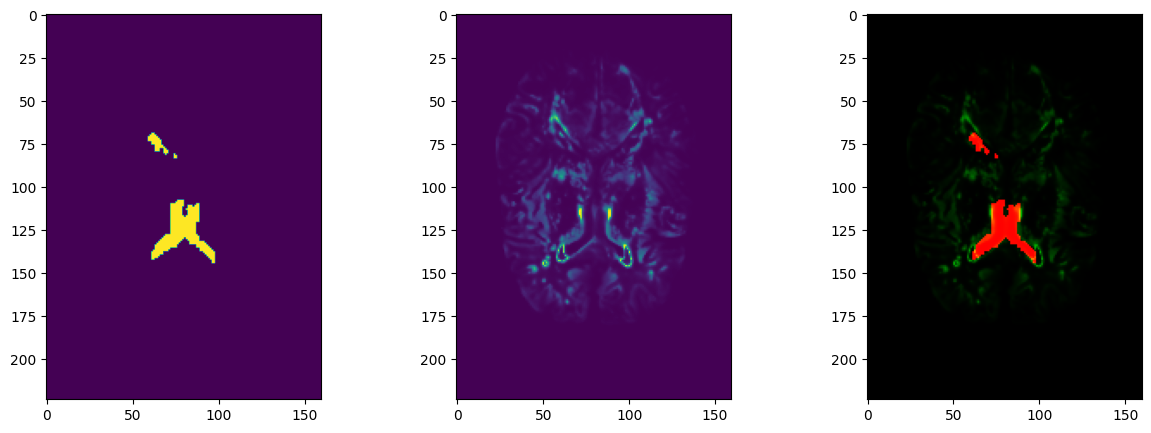

In [30]:
islice = 32
scan_id = 200
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(vent_maps[scan_id][islice])
plt.subplot(1,3,2)
plt.imshow(output_maps_for_umaps[IDs[scan_id][1]][0][islice])
plt.subplot(1,3,3)
img_map = torch.zeros(*vent_maps[scan_id].shape[1:], 3)
print(output_maps_for_umaps[IDs[scan_id][1]][0].shape)
print(vent_maps[scan_id].shape)
img_map[:,:,0] = vent_maps[scan_id][islice]
img_map[:,:,1] = output_maps_for_umaps[IDs[scan_id][1]][0][islice]
plt.imshow(img_map)

### distance from the ventricles

In [31]:
import torch.nn.functional as F
def edge_pixels_3D(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32).unsqueeze(0)
    
    max_pool = F.max_pool3d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool3d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype).squeeze()

def edge_pixels(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32)
    
    max_pool = F.max_pool2d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool2d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype)

In [32]:
def downsample_3d(img, avg=True):
    if avg:
        return F.avg_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)
    else:
        return F.max_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)

In [33]:
def min_distances(img, vmap):
    # calculate the minimum distance between each point in a and each point in b
    
    spatial_dims = vmap.squeeze().shape
    grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                indexing='ij'
            )
        ).type(torch.float32).to(img.device)
    
    a = grid[:, img.squeeze() > 0].T.cuda()
    b = grid[:, vmap.squeeze() > 0].T.cuda()
    
    # Calculate pairwise distances between all pairs of points
    distances = torch.cdist(a, b)

    # Find indices of closest points in b for each point in a
    _, indices = torch.min(distances, dim=1)

    # Use indices to index into b and get closest points
    b_closest = b[indices]

    # Calculate distances to closest points 
    distances_closest = torch.norm(a - b_closest, dim=1)
    
    distance_map = torch.zeros(img.shape).to(distances_closest.device)
    distance_map[img > 0] = distances_closest
    
    return distances_closest, distance_map

### connected components analysis

In [34]:
import cc3d

In [35]:
def get_conn_comps(img):
    connectivity = 6 # only 4,8 (2D) and 26, 18, and 6 (3D) are allowed
    labels_out_seg = cc3d.connected_components(img.cpu().numpy(), connectivity=connectivity)
    return torch.from_numpy(labels_out_seg.astype(np.int16)).to(img.device)

In [36]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

In [37]:
def skew(t, dim=None):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`

    :return: a scalar
    """

    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(3)).mean(dim=dim)


def kurtosis(t, fisher=True, dim=None):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)

    :return: a scalar
    """
        
    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(4)).mean(dim=dim) - fisher*3

In [38]:
def one_hot_encoded_image(image):
    # for a 3D [H, W, D] shape image
    # ensure all IDs are unique
    return (image == image.unique().view(-1, 1, 1, 1))

def one_hot_encoded_vector(vector):
    return (vector == vector.unique().view(-1,1))

In [39]:
def conn_comp_basic_stats(umap, conn_comp_map, seg_map, dist_map):
    # number of connected components
    # size of connected components
    # connected component size distribution information
    cc_ids = conn_comp_map.unique()
    cc_locs = conn_comp_map != 0
    conn_comp_map = conn_comp_map[cc_locs]
    umap = umap[cc_locs]
    seg_map = seg_map[cc_locs]
    dist_map = dist_map[cc_locs]
    
    assert dist_map.shape == seg_map.shape == umap.shape == conn_comp_map.shape
    num_ccs = len(cc_ids) - 1
    num_ccs_no_overlap = 0
    cc_sizes = []
    cc_means = []
    cc_stds = []
    cc_skews = []
    cc_kurts = []
    cc_vent_dists = []
    for cc_id in cc_ids:
        if cc_id == 0:
            continue
        cc = conn_comp_map == cc_id
        cc_size = cc.sum().item()
        cc_values = umap[cc]
        _, mean, std, skew, kurtosis = gaussian_summary_statistics(cc_values.cpu())
    
        cc_sizes.append(cc_size)
        cc_means.append(mean)
        cc_stds.append(std)
        cc_skews.append(skew)
        cc_kurts.append(kurtosis)
        
        if seg_map[cc].sum() == 0:
            num_ccs_no_overlap += 1
            
        cc_vent_dists.append(dist_map[cc].mean().item())
    _, vd_mean, vd_std, vd_skew, vd_kurt = gaussian_summary_statistics(torch.Tensor(cc_vent_dists))
    _, size_mean, size_std, size_skew, size_kurt = gaussian_summary_statistics(torch.Tensor(cc_sizes))
    
    return {"num":num_ccs, "sizes":cc_sizes, "means":cc_means, "stds":cc_stds, "skews":cc_skews, "kurts":cc_kurts, "vent_dists":cc_vent_dists, "unsegmented_ccs":num_ccs_no_overlap, "size_mean":size_mean, "size_std":size_std, "size_skew":size_skew, "size_kurt":size_kurt, "vd_mean":vd_mean, "vd_std":vd_std, "vd_skew":vd_skew, "vd_kurt":vd_kurt}



In [40]:
# idx = 0
# example_umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
# example_smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
# example_vmap = vent_maps[idx].cuda()

# vmap_ds = downsample_3d(example_vmap)
# umap_ds = downsample_3d(example_umap)
# ut_ds = umap_ds > 0.1
# ut = example_umap > 0.1
# conn_comps = get_conn_comps(ut)

# distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
# distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), example_umap.shape, mode='trilinear').squeeze()

In [41]:
# cc_data = conn_comp_basic_stats(example_umap, conn_comps, example_smap, distance_map) # from this we could get the mean mean, mean std, mean skew and mean kurtosis for each threshold I guess. # that would be somewhat interesting

In [42]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [43]:
# cc_data["log_sizes"] = torch.Tensor(cc_data['sizes']).log()
# sns.jointplot(cc_data, y="vent_dists", x="log_sizes", bins=5, kind='hist')

In [44]:
def joint_hist_values(data, x, y, minx, maxx, miny, maxy, bins=5):
    values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
    values = values.expand((bins, bins, *values.shape))
    counts = torch.zeros(bins, bins)
    bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1)).to(values.device)
    bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1)).to(values.device)
    upper_xlims = bounds_x[1:].view(1, 5, 1)
    upper_ylims = bounds_y[1:].view(5, 1, 1)
    lower_xlims = bounds_x[:-1].view(1, 5, 1)
    lower_ylims = bounds_y[:-1].view(5, 1, 1)
    counts = (values[:,:,:,0] < upper_xlims) * (values[:,:,:,0] > lower_xlims) * (values[:,:,:,1] < upper_ylims) * (values[:,:,:,1] > lower_ylims)
    counts = counts.sum(dim=-1)

    Z = counts.sum()
    counts = counts / Z
    return counts


# def joint_hist_values2(data, x, y, minx, maxx, miny, maxy, bins=5):
#     values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
#     #values = values.expand((bins, bins, *values.shape))
#     counts = torch.zeros(bins, bins)
#     bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1))
#     bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1))
#     upper_xlims = bounds_x[1:]
#     upper_ylims = bounds_y[1:]
#     lower_xlims = bounds_x[:-1]
#     lower_ylims = bounds_y[:-1]
#     for i, (x1, x2) in enumerate(zip(lower_xlims, upper_xlims)):
#         for j, (y1,y2) in enumerate(zip(lower_ylims, upper_ylims)):
#             counts[i][j] = ((values[:,0] < x2) * (values[:,0] > x1) * (values[:,1] < y2) * (values[:,1] > y1)).sum()
#     # counts = counts.sum(dim=-1)

#     Z = counts.sum()
#     counts = counts / Z
#     return counts

In [45]:
# joint_counts = joint_hist_values2(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5)

In [46]:
# joint_counts.shape

In [47]:
# plt.imshow(joint_counts); plt.colorbar()

In [48]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [49]:
# summary statistics of log conn comp size:
# cc_summary_stats = gaussian_summary_statistics(torch.Tensor(cc_data['sizes']).log())

In [50]:
# sum, mean , std, skew, kurtosis of log size of connected components.
# cc_summary_stats

In [51]:
# histogram_distribution(torch.Tensor(cc_data['sizes']).log(), 10)

In [52]:
# plt.hist(torch.Tensor(cc_data['sizes']).log(), bins=10);

In [53]:
# sns.jointplot(data=cc_data, x="sizes", y="kurts")
# plt.xscale('log')

In [54]:
# lets get basic distribution of connected component numbers and size. Then we can get some interesting plots later, so collect as much interesting information as possible...
# I can compare this to number and size of connected components in the predicted map (at say tau > 0.5?)
# I should get distance of each connected component from the ventricles and size. yes that is a good plot
# also distance from the binarized segmentation... (but I need to be careful and do this for pred as well as umap).

### Uncertainty values that I intended to extract from the umap

For SSN Ens for the ent and var maps, and SSN Ens Mean for the pred and seg maps. Nice.
I should capture all of these metrics across a variety of metrics, and I can tune the thresholds in cross validation. simples.
It may be the case that ent + var together give us some more information. That would be interesting.

`output_maps_for_umaps` is the SSN_Ens output
`output_maps_for_mean` is the SSN_Ens_mean output

- [x] sum
- [x] mean
- [x] std
- [x] skew
- [x] kurtosis
- [x] kde bins?
- [x] ventricle size
- [x] intensity distribution (need to ensure that the min and max of the bins are the same across all individuals) 
- [x] number of connected components
- [x] size of connected components distribution, need to ensure that the min and max of the bins are the same across all individuals.
- [x] number / distribution of connected components that have no overlap with the segmented mask... (again I need the umap and the pred map to do this) (and I should also compare to the seg map as well perhaps)
- [x] uncertainty sum, mean, skew, kurtosis of each connected component. That may be interesting to plot.
- [-] distance to the WMH binarized segmentation for each connected component (try to separate out those connected components that are highlighting other stuff).
- [-] proportion of the segmented edge deemed uncertain (if we expand the edge of the segmentation then calculate the proportion, we can get the sum of the uncertainty that
- [x] proportion of segmented area deemed uncertain (this requires access to SSN Ens and SSN Ens Mean at the same time
- [x] proportion of uncertain area that is within the segmentation + edge area
- [x] distribution of size of connected components (sum, mean, std, skew)
- [x] distance from the ventricles (could do this in x, y and z distributions, or just overall...) I could measure distance x intensity
- [x] stats for distance from the ventricles (mean, std, skew, kurtosis, etc)
- [x] mean distance from the ventricles of each connected component joint with size in a 5x5 and 10x10 bin option I think. again ensure that the 
- [ ] predicted seg volume.

### turning all of the above into a big loop

need to compute values for:
- [x] ent map
- [x] var map
- [x] pred map
- [x] loop over [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5] as threshold for ent map
- [x] loop over [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] for pred map
- [x] loop over ? for ent map

In [55]:
data = {}
failed_ids = []
for idx in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[idx][0]
    print(ID)
    try:
        vmap = vent_maps[idx].cuda()
        smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
        smap_expanded = get_edge_expanded_seg(smap)
        seg_volume = smap.sum().item()
        vent_volume = vmap.sum().item()
        vmap_ds = downsample_3d(vmap)

        ind_data = {}

        for input_type in ["ent", "var", "pred"]:
            if input_type == "ent":
                umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]
                maxv = 0.7
            elif input_type == "var":
                umap = output_maps_for_umaps[IDs[idx][1]][3].cuda()
                ts = [0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
                maxv = 0.2
            elif input_type == "pred":
                umap = output_maps_for_pred[IDs[idx][1]][1].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
                maxv = 1.0
            else:
                raise ValueError  

            umap_ds = downsample_3d(umap)

            collected_data_t = {}

            for t in ts:
                ut = umap > t
                umap_values = umap[ut]

                #### summary statistics
                sum, mean, std, skew, kurtosis = gaussian_summary_statistics(umap_values.cpu())
                values_hist = histogram_distribution(umap_values, bins=20, minv=t, maxv=maxv)

                #### overlap statistics
                intersection = (ut * smap).sum()
                expanded_intersection = (ut * smap_expanded).sum()

                prop_umap_segmented = (intersection / ut.sum()).item()
                prop_umap_within_expanded_seg = (expanded_intersection / ut.sum()).item()
                prop_seg_uncertain = (intersection / smap.sum()).item()

                ### ventricle distance statistics
                ut_ds = umap_ds > t
                distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
                distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), umap.shape, mode='trilinear').squeeze()
                _, dist_mean, dist_std, dist_skew, dist_kurt = gaussian_summary_statistics(distances_closest.cpu())
                umap_ds_values = umap_ds[ut_ds]
                dist_value_joint = joint_hist_values({"x":distances_closest, "y":umap_ds_values}, x="x", y="y", minx=0, maxx=30, miny=t, maxy=maxv, bins=5).cpu()

                ### connected component analysis statistics
                conn_comps = get_conn_comps(ut)
                cc_data = conn_comp_basic_stats(umap, conn_comps, smap, distance_map)
                cc_data["log_sizes"] = torch.Tensor(cc_data["sizes"]).log()
                cc_size_dist_joint = joint_hist_values(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5).cpu()

                # recorded values
                all_data = {}
                for key, value in cc_data.items():
                    all_data["cc_" + key] = value
                all_data["sum"] = sum
                all_data["mean"] = mean
                all_data["std"] = std
                all_data["skew"] = skew
                all_data["kurtosis"] = kurtosis
                all_data["prop_umap_segmented"] = prop_umap_segmented
                all_data["prop_umap_within_expanded_seg"] = prop_umap_within_expanded_seg
                all_data["prop_seg_uncertain"] = prop_seg_uncertain
                all_data["dist_mean"] = dist_mean
                all_data["dist_std"] = dist_std
                all_data["dist_skew"] = dist_skew
                all_data["dist_kurt"] = dist_kurt
                all_data["dist_value_joint"] = dist_value_joint
                all_data["cc_dist_value_joint"] = cc_size_dist_joint
                all_data["seg_volume"] = seg_volume
                all_data["vent_volume"] = vent_volume
                all_data["values_hist"] = values_hist

                print(all_data["cc_num"], all_data["cc_unsegmented_ccs"])
                collected_data_t[str(t)] = all_data


                # break

            ind_data[input_type] = collected_data_t
            # break

        data[ID] = ind_data
        # break
    except:
        failed_ids.append((idx, ID))
        

  0%|                                                                                                                                                                 | 0/250 [00:00<?, ?it/s]

CVD001


/tmp/ipykernel_2523046/1284179010.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = scipy.stats.skew(values)
/tmp/ipykernel_2523046/1284179010.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = scipy.stats.kurtosis(values, fisher=False)


97 96
109 108
86 85
64 63
49 48
41 40
147 146
103 102
120 116
129 88
112 60
48 26
22 21
22 19
11 6


  0%|▌                                                                                                                                                        | 1/250 [00:06<26:37,  6.41s/it]

14 6
11 0
7 0
CVD002
371 364
272 262
155 134
195 128
210 111
242 115
311 297
234 190
303 191
241 142
136 68
53 22
46 30
55 34
44 17
40 11


  1%|█▏                                                                                                                                                       | 2/250 [00:15<32:31,  7.87s/it]

35 0
27 0
CVD003
243 239
177 163
155 97
398 155
593 187
843 265
266 215
484 241
757 306
653 240
313 127


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1417: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)


80 52
49 30
38 16
32 7
36 5
34 0


  1%|█▊                                                                                                                                                       | 3/250 [00:30<46:44, 11.35s/it]

32 0
CVD004
236 224
154 138
139 112
141 86
156 82
182 89
196 176
193 144
229 134
183 97
91 49
41 19
79 42
83 34
77 25
75 14
68 0


  2%|██▍                                                                                                                                                      | 4/250 [00:38<40:06,  9.78s/it]

67 0
CVD008
151 133
143 114
157 95
307 142
480 202
706 290
204 140
512 248
581 237
320 99
123 37
63 20
79 38
80 30
72 15
77 11
73 0


  2%|███                                                                                                                                                      | 5/250 [00:50<43:24, 10.63s/it]

73 0
CVD009
539 530
413 397
343 296
321 223
356 212
457 243
465 418
521 362
489 317
327 197
144 104
73 64
118 88
86 54
67 32
60 19


  2%|███▋                                                                                                                                                     | 6/250 [01:04<47:53, 11.78s/it]

57 0
44 0
CVD011
385 367
255 227
195 146
202 134
224 138
230 132
346 315
266 203
266 192
166 109
120 72
59 29
106 68
81 36
77 29
66 12
56 0


  3%|████▎                                                                                                                                                    | 7/250 [01:13<44:39, 11.03s/it]

55 0
CVD012
387 381
300 292
232 212
140 93
154 76
219 95
310 300
305 267
331 245
250 150
172 82
76 44
44 26
36 16
33 11
35 9
30 0


  3%|████▉                                                                                                                                                    | 8/250 [01:23<42:13, 10.47s/it]

28 0
CVD013
128 120
113 97
110 79
137 59
169 63
218 80
156 137
132 86
191 81
166 74
81 45
37 20
35 19
29 10
29 7
34 9


  4%|█████▌                                                                                                                                                   | 9/250 [01:28<36:18,  9.04s/it]

30 0
29 0
CVD014
471 466
306 295
198 178
174 138
180 121
204 120
402 392
345 294
380 296
287 198
150 100
60 35
75 48
67 32
79 33
80 21
76 0


  4%|██████                                                                                                                                                  | 10/250 [01:39<38:02,  9.51s/it]

77 0
CVD016
240 212
167 130
201 130
371 180
518 206
826 304
266 179
734 342
930 397
450 198
195 88
94 41
115 63
109 48
99 29
101 16
105 0


  4%|██████▋                                                                                                                                                 | 11/250 [01:55<45:14, 11.36s/it]

88 0
CVD017
288 278
163 149
105 78
115 59
128 63
135 58
229 211
182 130
164 88
127 69
64 34
30 19
43 23
43 21
39 14
41 9


  5%|███████▎                                                                                                                                                | 12/250 [02:01<38:53,  9.80s/it]

36 0
30 0
CVD018
195 195
89 89
45 45
6 6
3 3
1 1
198 198
72 72
49 49
22 22
1 1
0 0
0 0
0 0
0 0
0 0


  5%|███████▉                                                                                                                                                | 13/250 [02:04<30:21,  7.69s/it]

0 0
0 0
CVD019
298 290
174 159
112 88
106 62
117 57
161 79
215 201
178 148
174 113
165 88
92 49
52 30
48 20
47 17
43 8
41 5


  6%|████████▌                                                                                                                                               | 14/250 [02:10<28:39,  7.29s/it]

39 0
38 0
CVD020
233 222
249 224
236 192
271 182
325 183
449 205
288 252
419 277
560 291
356 197
159 96
83 47
111 55
122 50
103 29
98 17
84 0


  6%|█████████                                                                                                                                               | 15/250 [02:23<35:01,  8.94s/it]

84 0
CVD021
339 312
242 204
222 166
259 153
322 164
408 186
318 275
363 247
375 219
285 155
204 98
127 70
130 73
101 40
90 25
80 10
82 0


  6%|█████████▋                                                                                                                                              | 16/250 [02:35<38:33,  9.89s/it]

81 0
CVD023
522 512
307 290
218 173
284 156
360 163
456 192
443 408
470 327
443 265
242 115
106 47
35 15
81 57
67 34
55 20
53 14


  7%|██████████▎                                                                                                                                             | 17/250 [02:48<41:59, 10.81s/it]

43 0
35 0
CVD024
239 229
133 119
126 88
165 83
187 86
222 96
200 168
247 142
213 117
100 49
62 30
26 12
49 34
31 13
32 9
32 5


  7%|██████████▉                                                                                                                                             | 18/250 [02:55<37:18,  9.65s/it]

30 0
28 0
CVD025
145 139
102 89
185 103
428 165
695 220
1067 312
312 164
1128 423
845 355
313 142
79 39
24 12
75 57
52 29
47 22
47 12


  8%|███████████▌                                                                                                                                            | 19/250 [03:12<45:25, 11.80s/it]

41 0
33 0
CVD028
159 147
152 135
199 148
453 184
683 241
1069 338
242 164
890 355
1052 450
517 201
206 45
78 6
67 40
70 30
70 25
63 10
71 0


  8%|████████████▏                                                                                                                                           | 20/250 [03:29<51:35, 13.46s/it]

80 0
CVD030
413 402
251 239
129 109
91 47
115 57
126 59
314 301
237 211
200 154
143 90
83 44
36 16
54 32
39 15
36 6
38 5


  8%|████████████▊                                                                                                                                           | 21/250 [03:36<44:20, 11.62s/it]

41 0
42 0
CVD031
295 283
218 197
189 153
304 187
421 215
623 278
278 244
523 300
661 308
395 166
161 64
111 29
97 60
115 60
101 38
108 23
107 0


  9%|█████████████▍                                                                                                                                          | 22/250 [03:51<47:14, 12.43s/it]

99 0
CVD032
203 188
144 119
154 99
182 94
206 94
249 103
199 157
245 151
249 141
124 66
50 29
23 12
65 31
59 21
52 10
52 7


  9%|█████████████▉                                                                                                                                          | 23/250 [03:58<41:38, 11.00s/it]

50 0
46 0
CVD033
382 371
260 239
241 168
317 159
429 190
563 227
345 304
463 316
529 261
442 206
246 142
78 54
78 38
76 26
70 14
63 2
68 0


 10%|██████████████▌                                                                                                                                         | 24/250 [04:12<44:38, 11.85s/it]

67 0
CVD034
509 498
367 345
266 204
242 115
308 135
364 133
486 437
529 379
401 241
223 119
148 60
90 34
86 45
84 37
78 23
68 6
73 0


 10%|███████████████▏                                                                                                                                        | 25/250 [04:25<45:52, 12.24s/it]

70 0
CVD035
189 184
127 119
105 90
79 49
98 47
107 36
154 147
136 111
164 101
141 76
76 37
31 19
24 14
15 5
14 4


 10%|███████████████▊                                                                                                                                        | 26/250 [04:30<37:21, 10.01s/it]

12 1
11 0
13 0
CVD036
257 245
187 159
248 155
516 191
787 248
1143 341
363 256
950 394
900 344
396 158
147 56
51 23
77 38
70 26
64 17
69 14
59 0


 11%|████████████████▍                                                                                                                                       | 27/250 [04:48<45:55, 12.36s/it]

59 0
CVD037
138 138
36 36
11 11
0 0
0 0
0 0
67 67
29 29
6 6
0 0
0 0
0 0
0 0


 11%|█████████████████                                                                                                                                       | 28/250 [04:50<33:51,  9.15s/it]

0 0
0 0
0 0
0 0
0 0
CVD038
204 185
163 136
143 104
182 84
265 116
315 127
180 138
293 169
287 149
179 76
113 46
49 23
71 38
75 36
67 25
60 14


 12%|█████████████████▋                                                                                                                                      | 29/250 [04:58<32:41,  8.88s/it]

53 0
49 0
CVD039
240 216
146 110
202 116
326 151
414 170
546 226
238 162
418 217
449 235
368 197
213 136
71 43
89 39
86 25
86 17
93 12
92 0


 12%|██████████████████▏                                                                                                                                     | 30/250 [05:10<36:29,  9.95s/it]

84 0
CVD040
212 201
179 153
235 153
390 169
517 203
661 250
301 214
597 272
500 223
278 132
120 47
52 20
69 44
66 36
63 25
60 12
64 0


 12%|██████████████████▊                                                                                                                                     | 31/250 [05:23<38:57, 10.67s/it]

66 0
CVD041
337 333
202 188
218 148
377 158
547 199
817 271
344 246
709 310
636 294
276 147
85 48
23 20
63 44
40 17
41 16
38 8


 13%|███████████████████▍                                                                                                                                    | 32/250 [05:37<42:56, 11.82s/it]

37 0
34 0
CVD042
329 319
196 184
139 119
129 69
151 66
164 70
270 253
232 173
218 152
94 67
40 26
16 9
29 17
27 13
21 5
19 2
20 0


 13%|████████████████████                                                                                                                                    | 33/250 [05:44<37:09, 10.27s/it]

21 0
CVD043
210 207
133 123
157 115
215 120
249 113
291 111
187 153
268 168
224 125
136 67
64 32
24 16
33 20
32 16
30 11
29 8


 14%|████████████████████▋                                                                                                                                   | 34/250 [05:51<33:49,  9.40s/it]

23 0
23 0
CVD045
284 257
187 148
203 124
395 183
607 228
927 346
328 230
779 371
930 408
435 197
183 38
105 24
111 53
107 39
108 27
107 16
107 0


 14%|█████████████████████▎                                                                                                                                  | 35/250 [06:09<42:40, 11.91s/it]

104 0
CVD047
629 614
433 402
335 279
337 229
345 201
404 197
495 448
496 371
436 292
311 184
157 98
91 53
138 91
106 53
106 44
102 27
94 0


 14%|█████████████████████▉                                                                                                                                  | 36/250 [06:23<45:21, 12.72s/it]

83 0
CVD048
429 407
294 255
258 190
319 177
417 185
577 230
346 299
457 288
598 280
404 165
172 69
43 18
126 66
117 40
109 24
114 15
109 0


 15%|██████████████████████▍                                                                                                                                 | 37/250 [06:38<47:04, 13.26s/it]

113 0
CVD049
272 260
191 174
124 88
151 62
172 61
216 67
227 196
237 149
229 109
159 66
100 56
52 25
49 25
43 18
46 15
37 5


 15%|███████████████████████                                                                                                                                 | 38/250 [06:46<40:50, 11.56s/it]

34 0
33 0
CVD050
192 181
169 141
143 109
165 86
223 111
297 142
198 167
233 158
353 204
228 129
155 84
78 37
86 33
90 31
80 18
81 12
72 0


 16%|███████████████████████▋                                                                                                                                | 39/250 [06:54<37:38, 10.70s/it]

76 0
CVD052
521 464
419 345
399 284
459 258
481 244
541 244
480 379
539 346
469 275
344 198
243 143
168 103
186 102
145 59
131 39
124 16
115 0


 16%|████████████████████████▎                                                                                                                               | 40/250 [07:11<43:34, 12.45s/it]

116 0
CVD055
292 278
205 184
107 80
98 54
102 50
113 54
220 199
185 155
146 96
129 74
70 37
57 28
51 28
48 20
47 15
38 4
36 0


 16%|████████████████████████▉                                                                                                                               | 41/250 [07:17<37:11, 10.68s/it]

39 0
CVD056
177 165
98 82
86 63
86 44
90 44
89 38
130 112
93 69
86 52
86 45
81 36
51 20
44 23
35 13
30 7
29 1


 17%|█████████████████████████▌                                                                                                                              | 42/250 [07:22<30:30,  8.80s/it]

30 0
31 0
CVD060
342 317
224 182
180 106
316 123
491 179
659 254
304 249
403 238
549 270
556 251
415 204
110 53
121 36
124 24
125 17
133 11
132 0


 17%|██████████████████████████▏                                                                                                                             | 43/250 [07:36<36:29, 10.58s/it]

125 0
CVD061
251 236
225 191
210 147
307 168
390 189
452 201
330 270
442 276
357 220
253 130
123 48
57 24
88 45
96 36
94 26
97 15
100 0


 18%|██████████████████████████▊                                                                                                                             | 44/250 [07:49<37:56, 11.05s/it]

94 0
CVD063
441 417
310 277
263 211
224 155
234 143
266 140
343 304
328 253
315 210
285 178
195 113
96 61
93 48
72 25
69 19
66 15
56 0


 18%|███████████████████████████▎                                                                                                                            | 45/250 [07:59<37:02, 10.84s/it]

54 0
CVD064
309 306
178 173
119 107
200 129
289 157
478 211
251 239
417 247
803 373
778 406
324 167
114 52
66 43
58 32
54 17
57 12
55 0


 18%|███████████████████████████▉                                                                                                                            | 46/250 [08:13<39:41, 11.67s/it]

57 0
CVD065
448 431
301 270
235 166
295 141
423 182
678 265
371 297
534 323
635 381
431 227
223 126
58 32
103 63
91 41
70 20
66 11


 19%|████████████████████████████▌                                                                                                                           | 47/250 [08:27<42:09, 12.46s/it]

64 0
55 0
CVD068
297 276
193 157
149 85
210 89
260 99
302 116
247 200
249 139
254 111
188 85
110 48
60 22
64 31
55 20
52 15
50 9


 19%|█████████████████████████████▏                                                                                                                          | 48/250 [08:36<38:16, 11.37s/it]

43 0
44 0
CVD070
249 240
240 221
235 182
220 115
270 123
346 146
274 236
327 215
409 229
314 158
124 54
43 28
72 42
55 19
56 15
51 7


 20%|█████████████████████████████▊                                                                                                                          | 49/250 [08:46<36:44, 10.97s/it]

51 0
49 0
CVD073
269 228
199 148
222 145
275 133
316 143
338 142
279 196
337 203
330 168
221 116
95 55
39 22
104 46
95 32
90 22
81 9
77 0


 20%|██████████████████████████████▍                                                                                                                         | 50/250 [08:56<35:53, 10.77s/it]

70 0
CVD074
289 269
175 152
146 116
165 112
193 107
257 121
230 199
231 158
291 148
227 105
130 68
45 20
79 49
72 34
71 27
59 9


 20%|███████████████████████████████                                                                                                                         | 51/250 [09:04<32:59,  9.95s/it]

53 0
51 0
CVD075
570 559
352 336
201 176
136 88
136 73
140 70
474 456
336 295
277 190
123 68
48 25
20 12
50 33
31 14
30 10
29 9
21 0


 21%|███████████████████████████████▌                                                                                                                        | 52/250 [09:13<32:06,  9.73s/it]

22 0
CVD076
251 222
212 168
205 127
275 119
359 151
455 180
253 190
335 184
360 168
274 133
141 59
46 15
101 45
92 29
91 23
87 15
79 0


 21%|████████████████████████████████▏                                                                                                                       | 53/250 [09:24<33:10, 10.10s/it]

78 0
CVD077
427 420
282 273
225 190
279 155
355 173
494 186
351 314
520 291
554 301
310 162
182 100
78 43
64 47
49 24
46 16
43 9


 22%|████████████████████████████████▊                                                                                                                       | 54/250 [09:37<35:37, 10.91s/it]

44 0
46 0
CVD078
337 305
193 153
155 101
203 105
215 100
230 109
236 193
205 133
212 118
157 79
70 35
32 17
79 37
70 24
65 13
62 7
58 0


 22%|█████████████████████████████████▍                                                                                                                      | 55/250 [09:45<32:12,  9.91s/it]

52 0
CVD079
480 470
344 327
257 228
186 141
167 112
173 105
386 368
335 304
275 221
221 166
118 78
66 49
55 32
43 17
37 10
32 4


 22%|██████████████████████████████████                                                                                                                      | 56/250 [09:54<31:29,  9.74s/it]

29 0
27 0
CVD080
307 303
257 241
202 166
144 80
157 77
184 92
297 270
294 234
277 205
164 128
53 40
23 13
51 32
44 23
31 9
26 2
31 0


 23%|██████████████████████████████████▋                                                                                                                     | 57/250 [10:01<29:08,  9.06s/it]

29 0
CVD081
471 467
283 278
182 168
159 118
188 117
208 94
358 348
256 225
256 150
212 122
117 74
39 17
44 27
41 21
36 13
34 7


 23%|███████████████████████████████████▎                                                                                                                    | 58/250 [10:10<28:54,  9.03s/it]

33 0
36 0
CVD082
315 306
192 179
122 104
94 65
105 63
118 61
224 211
165 141
151 108
140 75
61 19
20 11
47 29
38 16
40 13
34 5


 24%|███████████████████████████████████▊                                                                                                                    | 59/250 [10:17<25:59,  8.17s/it]

31 0
30 0
CVD083
682 670
543 517
334 282
361 220
462 229
639 275
645 602
691 530
693 397
435 253
257 138
79 36
132 84
115 53
120 42
119 27
109 0


 24%|████████████████████████████████████▍                                                                                                                   | 60/250 [10:35<35:46, 11.30s/it]

92 0
CVD084
517 498
350 320
239 196
252 155
273 139
299 139
415 383
345 260
385 245
243 171
118 77
76 45
68 38
69 33
59 20
50 6


 24%|█████████████████████████████████████                                                                                                                   | 61/250 [10:46<35:08, 11.16s/it]

47 0
42 0
CVD085
315 305
185 171
128 104
165 102
202 109
243 126
227 205
233 168
271 161
186 115
79 48
33 21
58 39
45 21
44 14
43 12


 25%|█████████████████████████████████████▋                                                                                                                  | 62/250 [10:54<32:07, 10.25s/it]

37 0
32 0
CVD086
231 213
152 131
127 95
156 76
193 75
243 84
193 156
238 147
241 126
175 94
103 45
68 27
70 31
64 21
55 10
60 9
56 0


 25%|██████████████████████████████████████▎                                                                                                                 | 63/250 [11:02<29:22,  9.42s/it]

53 0
CVD088
414 401
246 217
182 127
247 123
307 128
362 147
321 285
336 210
365 185
211 114
99 33
36 23
50 29
38 16
41 14
33 4


 26%|██████████████████████████████████████▉                                                                                                                 | 64/250 [11:11<29:34,  9.54s/it]

32 0
27 0
CVD089
271 248
194 160
168 108
236 110
295 122
380 138
243 196
333 187
317 153
205 95
106 45
45 17
77 41
73 27
70 20
68 14
60 0


 26%|███████████████████████████████████████▌                                                                                                                | 65/250 [11:22<29:52,  9.69s/it]

63 0
CVD090
209 194
127 104
119 81
135 80
186 97
227 101
173 141
177 106
243 137
175 85
86 49
45 21
67 42
52 23
46 15
35 3


 26%|████████████████████████████████████████▏                                                                                                               | 66/250 [11:28<27:11,  8.87s/it]

36 0
32 0
CVD091
237 230
143 132
97 83
99 57
107 56
115 57
182 171
161 123
161 96
112 57
61 27
38 21
44 27
33 13
31 8
29 3


 27%|████████████████████████████████████████▋                                                                                                               | 67/250 [11:34<23:55,  7.85s/it]

33 0
25 0
CVD092
269 262
123 115
95 75
120 62
128 60
148 58
148 139
137 102
174 95
154 76
88 47
30 19
25 15
21 9
25 9
26 5


 27%|█████████████████████████████████████████▎                                                                                                              | 68/250 [11:40<21:52,  7.21s/it]

23 0
24 0
CVD096
316 297
197 175
138 115
119 79
145 88
159 80
233 210
174 140
178 114
166 88
88 42
31 16
63 39
52 24
42 13
41 10


 28%|█████████████████████████████████████████▉                                                                                                              | 69/250 [11:47<21:43,  7.20s/it]

32 0
29 0
CVD097
275 259
170 142
132 97
143 79
153 72
177 70
231 201
167 129
182 99
125 48
78 36
42 17
58 26
53 20
45 9
39 3
38 0


 28%|██████████████████████████████████████████▌                                                                                                             | 70/250 [11:54<21:18,  7.11s/it]

38 0
CVD098
432 412
277 252
210 154
237 120
275 117
343 144
359 316
350 248
395 235
285 155
134 70
62 35
47 19
53 20
52 16
47 6


 28%|███████████████████████████████████████████▏                                                                                                            | 71/250 [12:05<24:34,  8.24s/it]

47 0
46 0
CVD100
416 405
229 214
127 92
154 79
194 88
243 97
306 285
279 194
290 162
173 93
89 52
39 22
43 25
37 16
35 10
35 8


 29%|███████████████████████████████████████████▊                                                                                                            | 72/250 [12:13<24:31,  8.27s/it]

32 0
27 0
CVD102
243 236
177 165
162 112
314 144
459 187
682 239
254 196
592 280
737 323
398 189
162 87
44 25
75 53
68 37
51 15
56 12
51 0


 29%|████████████████████████████████████████████▍                                                                                                           | 73/250 [12:26<28:43,  9.74s/it]

52 0
CVD103
251 239
161 142
136 102
200 104
287 120
444 167
250 226
349 208
630 308
495 254
249 149
91 56
65 37
55 25
55 21
55 13
53 0


 30%|████████████████████████████████████████████▉                                                                                                           | 74/250 [12:38<30:08, 10.28s/it]

51 0
CVD104
295 285
151 138
84 64
93 44
105 38
124 45
196 183
119 92
157 80
125 59
66 32
20 9
31 15
33 15
26 7
22 3


 30%|█████████████████████████████████████████████▌                                                                                                          | 75/250 [12:43<25:59,  8.91s/it]

21 0
18 0
CVD105
193 185
113 100
95 68
116 61
145 73
171 80
148 126
154 102
195 107
136 86
66 39
29 21
38 18
38 18
35 11
32 4


 30%|██████████████████████████████████████████████▏                                                                                                         | 76/250 [12:49<23:16,  8.03s/it]

32 0
32 0
CVD106
196 179
149 122
174 116
247 128
347 158
473 173
228 174
443 219
526 256
436 194
197 86
64 26
103 50
94 36
92 25
90 13
90 0


 31%|██████████████████████████████████████████████▊                                                                                                         | 77/250 [13:01<26:36,  9.23s/it]

84 0
CVD107
236 230
135 125
157 117
346 155
539 215
820 289
241 193
647 342
862 439
435 213
117 67
22 15
45 25
54 28
43 14
43 9
43 0


 31%|███████████████████████████████████████████████▍                                                                                                        | 78/250 [13:16<30:41, 10.71s/it]

40 0
CVD108
339 318
194 157
165 116
192 110
202 98
235 104
271 228
224 157
253 141
192 93
98 39
42 18
90 52
77 33
70 16
65 9
58 0


 32%|████████████████████████████████████████████████                                                                                                        | 79/250 [13:24<28:45, 10.09s/it]

55 0
CVD111
536 518
367 333
266 205
329 206
431 249
573 301
504 442
590 421
658 395
368 211
150 79
70 30
124 78
125 63
125 50
125 32
118 0


 32%|████████████████████████████████████████████████▋                                                                                                       | 80/250 [13:41<34:03, 12.02s/it]

112 0
CVD112
549 502
352 287
266 181
318 163
361 172
434 186
471 396
502 336
419 221
260 120
137 71
67 27
143 56
134 39
134 33
128 20
116 0


 32%|█████████████████████████████████████████████████▏                                                                                                      | 81/250 [13:56<36:15, 12.87s/it]

111 0
CVD113
520 516
354 349
249 236
168 121
181 111
219 118
395 386
342 288
372 271
230 175
123 89
70 54
55 31
60 26
57 20
52 9
46 0


 33%|█████████████████████████████████████████████████▊                                                                                                      | 82/250 [14:06<33:46, 12.07s/it]

44 0
CVD114
294 255
208 149
222 122
301 126
391 174
437 190
281 199
360 201
353 183
177 81
66 28
31 12
88 34
83 25
78 19
71 10
65 0


 33%|██████████████████████████████████████████████████▍                                                                                                     | 83/250 [14:17<32:41, 11.75s/it]

64 0
CVD115
304 288
225 202
218 161
335 145
545 198
769 249
355 285
584 281
714 311
515 195
249 126
89 53
98 61
82 43
63 20
52 4


 34%|███████████████████████████████████████████████████                                                                                                     | 84/250 [14:31<34:59, 12.65s/it]

59 0
57 0
CVD116
344 330
231 212
168 135
155 89
182 104
199 93
299 276
266 206
241 145
180 115
100 61
54 29
70 35
60 21
58 15
55 10
52 0


 34%|███████████████████████████████████████████████████▋                                                                                                    | 85/250 [14:40<31:15, 11.37s/it]

45 0
CVD117
257 251
164 153
155 128
199 128
215 117
248 123
212 191
235 165
224 133
193 105
101 45
39 21
69 54
59 38
58 29
49 12


 34%|████████████████████████████████████████████████████▎                                                                                                   | 86/250 [14:48<28:21, 10.38s/it]

43 0
46 0
CVD118
399 388
247 226
221 180
327 175
543 211
895 311
328 281
754 352
993 440
549 295
183 100
46 18
73 54
54 28
60 24
63 16


 35%|████████████████████████████████████████████████████▉                                                                                                   | 87/250 [15:04<33:02, 12.16s/it]

58 0
52 0
CVD121
348 317
247 207
189 133
229 136
252 138
286 149
254 206
278 190
269 160
223 122
112 56
53 31
115 57
100 30
93 19
90 6
93 0


 35%|█████████████████████████████████████████████████████▌                                                                                                  | 88/250 [15:14<31:13, 11.57s/it]

88 0
CVD124
501 489
360 336
280 225
311 180
397 198
487 211
447 403
415 304
479 294
463 243
230 132
67 38
111 64
86 32
91 26
92 14
91 0


 36%|██████████████████████████████████████████████████████                                                                                                  | 89/250 [15:29<33:07, 12.34s/it]

76 0
CVD126
275 251
195 162
177 117
272 129
394 162
534 201
229 176
434 230
479 232
239 119
87 42
50 20
75 26
77 23
84 24
76 13
68 0


 36%|██████████████████████████████████████████████████████▋                                                                                                 | 90/250 [15:40<32:06, 12.04s/it]

70 0
CVD127
307 294
187 166
142 110
138 80
168 88
186 86
250 224
205 149
208 118
198 113
136 75
63 42
58 33
50 21
45 14
46 6
52 0


 36%|███████████████████████████████████████████████████████▎                                                                                                | 91/250 [15:48<28:40, 10.82s/it]

54 0
CVD128
275 271
181 175
133 126
149 114
182 114
199 100
231 223
242 198
305 210
204 135
95 63
52 41
39 24
27 10
25 6
21 1


 37%|███████████████████████████████████████████████████████▉                                                                                                | 92/250 [15:55<25:35,  9.72s/it]

26 0
28 0
CVD129
309 301
188 169
170 133
200 111
279 126
401 133
253 217
368 227
554 216
456 172
209 86
103 39
87 60
75 37
63 17
65 12
63 0


 37%|████████████████████████████████████████████████████████▌                                                                                               | 93/250 [16:07<27:04, 10.35s/it]

64 0
CVD130
268 255
181 166
123 106
115 76
115 63
115 53
192 176
182 139
148 109
104 70
49 28
41 21
35 18
27 8
28 8
24 2
23 0


 38%|█████████████████████████████████████████████████████████▏                                                                                              | 94/250 [16:13<23:25,  9.01s/it]

22 0
CVD132
243 234
154 145
92 80
118 87
130 83
136 68
168 158
160 128
142 90
142 75
75 46
22 12
41 30
23 12
22 9
18 4


 38%|█████████████████████████████████████████████████████████▊                                                                                              | 95/250 [16:19<20:48,  8.05s/it]

17 0
19 0
CVD133
280 269
134 121
74 58
64 36
71 35
82 34
174 159
122 101
92 53
105 48
72 31
42 15
29 13
23 6
21 4
18 1
19 0


 38%|██████████████████████████████████████████████████████████▎                                                                                             | 96/250 [16:23<18:04,  7.04s/it]

21 0
CVD134
308 290
211 185
157 118
225 109
330 140
449 186
261 230
333 190
428 196
331 136
191 79
75 29
83 47
73 32
66 21
61 11
60 0


 39%|██████████████████████████████████████████████████████████▉                                                                                             | 97/250 [16:34<20:27,  8.02s/it]

49 0
CVD137
321 310
248 230
126 90
142 66
197 78
254 95
283 253
295 205
272 136
161 71
80 32
35 14
44 23
41 17
36 10
32 5


 39%|███████████████████████████████████████████████████████████▌                                                                                            | 98/250 [16:42<20:39,  8.15s/it]

29 0
34 0
CVD138
518 512
341 329
205 182
183 120
210 105
289 128
434 422
402 326
418 280
324 207
177 115
65 33
44 22
57 26
50 15
57 15
49 0


 40%|████████████████████████████████████████████████████████████▏                                                                                           | 99/250 [16:54<23:02,  9.16s/it]

53 0
CVD140
203 187
160 125
187 95
299 108
402 136
519 159
247 167
410 180
449 171
230 110
83 34
15 2
54 19
52 11
59 10
67 14
60 0


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 100/250 [17:04<24:03,  9.63s/it]

66 0
CVD141
309 298
210 190
177 154
150 105
193 115
241 118
246 227
238 194
286 180
231 115
116 58
45 23
88 54
74 36
69 25
56 8


 40%|█████████████████████████████████████████████████████████████                                                                                          | 101/250 [17:13<23:01,  9.27s/it]

51 0
50 0
CVD143
235 218
170 149
153 125
179 106
231 115
318 145
183 157
286 176
338 181
226 116
106 56
40 19
79 44
71 29
77 29
70 15
65 0


 41%|█████████████████████████████████████████████████████████████▌                                                                                         | 102/250 [17:21<22:31,  9.13s/it]

62 0
CVD145
267 256
197 182
139 117
108 70
116 74
139 78
237 222
180 159
170 131
175 103
159 80
98 50
54 26
53 22
50 12
55 10
51 0


 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 103/250 [17:29<21:01,  8.58s/it]

50 0
CVD146
444 432
331 312
254 216
235 127
280 122
350 144
375 333
354 260
427 269
242 139
99 50
45 20
76 49
72 37
60 23
50 9


 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 104/250 [17:41<23:10,  9.52s/it]

48 0
50 0
CVD148
339 324
301 278
221 182
170 93
200 93
222 99
320 291
356 280
329 257
176 115
64 34
25 14
40 18
35 13
33 7
30 3


 42%|███████████████████████████████████████████████████████████████▍                                                                                       | 105/250 [17:49<22:31,  9.32s/it]

29 0
28 0
CVD150
378 358
239 205
181 124
232 109
319 139
354 143
307 258
335 194
368 203
232 128
140 56
61 27
53 24
43 13
40 6
38 3
39 0


 42%|████████████████████████████████████████████████████████████████                                                                                       | 106/250 [17:59<22:52,  9.53s/it]

37 0
CVD151
365 354
238 220
200 160
275 154
339 165
423 187
310 284
387 235
432 219
270 130
153 72
89 37
99 65
71 33
69 22
61 8
59 0


 43%|████████████████████████████████████████████████████████████████▋                                                                                      | 107/250 [18:11<23:56, 10.05s/it]

59 0
CVD152
328 322
254 242
204 180
198 118
245 125
319 132
298 274
323 245
442 284
311 164
141 62
44 21
54 35
56 31
51 23
41 8


 43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 108/250 [18:21<23:48, 10.06s/it]

42 0
42 0
CVD153
291 271
199 174
155 102
247 116
345 137
488 175
268 226
381 186
416 178
248 90
116 43
50 19
92 57
72 30
65 19
60 7
56 0


 44%|█████████████████████████████████████████████████████████████████▊                                                                                     | 109/250 [18:31<23:53, 10.17s/it]

57 0
CVD155
176 169
111 102
87 59
101 45
136 51
177 70
136 116
183 122
194 98
109 58
43 18
16 7
26 12
27 8
27 7
24 2
26 0


 44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 110/250 [18:36<20:08,  8.63s/it]

20 0
CVD156
229 212
199 178
168 123
222 133
293 148
397 179
255 214
356 204
374 178
262 140
155 103
64 45
92 49
80 29
73 19
63 6
72 0


 44%|███████████████████████████████████████████████████████████████████                                                                                    | 111/250 [18:47<21:12,  9.16s/it]

78 0
CVD157
411 408
243 236
173 148
242 124
363 147
613 207
324 300
509 317
692 340
474 188
214 94
53 25
39 28
36 23
29 13
25 3
24 0


 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 112/250 [18:59<23:38, 10.28s/it]

25 0
CVD158
538 524
355 321
241 174
318 175
413 185
576 235
451 389
559 354
488 283
272 158
111 65
35 13
115 70
112 56
105 39
95 15
99 0


 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 113/250 [19:14<26:27, 11.58s/it]

88 0
CVD161
276 265
166 146
147 111
228 111
279 121
336 135
248 214
339 190
334 198
169 86
69 32
30 12
57 36
41 15
38 12
40 9


 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 114/250 [19:23<24:10, 10.66s/it]

37 0
37 0
CVD165
628 614
476 454
330 301
254 206
252 170
269 157
511 490
451 376
490 362
347 233
191 110
100 55
105 66
92 46
77 27
76 18
62 0


 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 115/250 [19:37<26:23, 11.73s/it]

65 0
CVD166
771 751
537 510
339 290
319 204
402 212
529 241
638 595
591 472
569 348
429 191
250 85
90 30
178 124
151 85
122 49
109 28
89 0


 46%|██████████████████████████████████████████████████████████████████████                                                                                 | 116/250 [19:54<30:08, 13.50s/it]

83 0
CVD167
329 316
204 186
163 131
280 141
428 173
681 204
286 239
553 263
683 281
402 175
139 69
58 22
82 53
75 42
53 18
51 10


 47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 117/250 [20:08<30:07, 13.59s/it]

48 0
43 0
CVD169
413 405
275 262
178 160
144 112
146 103
157 93
315 301
292 254
325 232
214 138
123 55
62 36
60 39
59 29
55 19
52 13
52 0


 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 118/250 [20:17<26:55, 12.24s/it]

65 0
CVD170
272 262
172 155
151 103
289 125
467 171
660 227
260 219
464 260
589 232
426 169
208 84
77 35
69 37
69 31
60 17
52 6
51 0


 48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 119/250 [20:31<27:21, 12.53s/it]

47 0
CVD171
343 336
250 239
216 190
198 145
245 150
292 155
268 250
292 220
307 220
233 160
134 84
86 56
69 51
52 28
53 22
54 15
45 0


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 120/250 [20:40<25:10, 11.62s/it]

39 0
CVD172
358 307
248 186
247 152
309 161
358 180
379 176
307 233
279 164
322 171
205 93
95 45
56 31
123 57
101 34
98 26
94 16
85 0


 48%|█████████████████████████████████████████████████████████████████████████                                                                              | 121/250 [20:51<24:36, 11.45s/it]

76 0
CVD173
467 455
279 258
293 210
508 232
714 282
1024 362
369 309
763 377
917 412
408 161
171 57
59 28
87 64
64 36
49 21
41 12
35 0


 49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 122/250 [21:09<28:35, 13.40s/it]

32 0
CVD174
256 250
181 169
150 114
290 141
421 168
700 270
228 194
488 254
684 305
396 177
94 48
51 21
68 46
71 44
74 35
67 17


 49%|██████████████████████████████████████████████████████████████████████████▎                                                                            | 123/250 [21:21<27:37, 13.05s/it]

57 0
49 0
CVD175
267 263
138 131
109 87
122 68
167 82
207 88
190 178
196 147
232 133
165 85
88 44
43 16
51 31
41 18
44 15
41 8


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 124/250 [21:28<23:25, 11.15s/it]

39 0
35 0
CVD176
278 259
192 161
190 140
261 130
339 143
398 154
257 209
371 217
359 176
177 77
82 52
43 20
77 45
68 34
64 25
51 11


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 125/250 [21:38<22:35, 10.84s/it]

45 0
45 0
CVD177
411 400
283 264
200 156
280 130
350 154
421 172
323 296
338 236
437 232
315 151
167 81
60 21
51 30
44 17
47 14
44 6
44 0


 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 126/250 [21:49<22:25, 10.85s/it]

47 0
CVD178
224 212
132 110
139 81
202 84
234 92
273 98
178 132
242 131
216 100
139 69
73 44
24 15
35 17
28 8
25 4
24 1


 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 127/250 [21:56<19:41,  9.61s/it]

24 0
25 0
CVD179
325 316
289 272
237 206
284 165
416 195
673 251
352 303
647 355
844 388
475 210
179 89
44 22
71 46
58 26
60 21
66 14


 51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 128/250 [22:10<22:24, 11.02s/it]

71 0
58 0
CVD181
294 280
197 180
187 132
324 135
517 184
758 251
321 246
721 366
678 317
374 172
131 52
60 21
76 47
70 32
61 15
63 12
67 0


 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 129/250 [22:24<24:06, 11.95s/it]

64 0
CVD183
202 197
112 98
89 57
96 48
124 60
151 64
146 121
149 103
178 87
135 56
66 33
18 9
37 19
37 16
35 13
29 3


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 130/250 [22:30<20:00, 10.01s/it]

28 0
29 0
CVD184
396 391
237 230
128 113
130 84
163 94
206 97
273 264
231 184
266 164
196 97
133 66
74 37
61 36
51 21
46 12
49 7


 52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 131/250 [22:37<18:34,  9.36s/it]

52 0
48 0
CVD186
295 291
234 222
202 184
150 112
200 124
268 142
292 273
323 259
447 289
395 207
244 118
107 48
80 52
72 35
91 42
83 21
82 0


 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 132/250 [22:49<19:32,  9.94s/it]

75 0
CVD188
282 265
190 156
216 139
366 149
520 174
721 232
268 192
573 275
478 172
289 54
64 14
19 5
98 60
82 39
72 25
64 11
65 0


 53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 133/250 [23:01<20:46, 10.65s/it]

53 0
CVD191
600 582
375 349
309 262
323 206
370 204
499 225
477 438
551 410
700 374
529 305
239 137
126 60
142 96
109 57
101 34
95 20
94 0


 54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 134/250 [23:18<24:02, 12.43s/it]

79 0
CVD192
359 351
207 198
136 118
130 92
148 99
169 100
261 250
193 166
174 123
161 101
140 73
92 50
79 52
60 28
55 18
51 9


 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 135/250 [23:25<21:07, 11.02s/it]

53 0
46 0
CVD193
415 407
267 255
214 196
166 129
156 105
156 88
332 322
259 229
233 157
186 109
118 72
56 34
89 59
65 30
56 19
50 10


 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 136/250 [23:34<19:40, 10.35s/it]

46 0
39 0
CVD194
203 192
113 99
86 71
76 42
85 35
93 28
126 112
106 79
101 51
102 49
76 33
44 22
26 6
30 3
38 3
41 2


 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 137/250 [23:39<16:18,  8.66s/it]

42 0
38 0
CVD195
211 207
170 163
140 105
318 144
554 190
841 247
298 234
814 328
875 377
331 167
136 63
33 15
21 13
25 13
22 10
21 5


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 138/250 [23:53<19:20, 10.36s/it]

22 0
22 0
CVD200
297 292
247 234
200 174
254 157
345 172
510 221
294 276
348 252
555 304
531 281
334 187
127 83
71 41
64 29
59 19
55 12


 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 139/250 [24:06<20:30, 11.09s/it]

55 0
54 0
CVD201
220 213
219 211
161 147
124 82
162 85
209 98
187 178
245 212
286 213
197 142
70 40
41 26
51 30
41 19
34 10
31 3


 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 140/250 [24:13<18:19,  9.99s/it]

33 0
28 0
CVD202
257 253
175 165
158 125
315 154
546 211
986 355
250 223
682 376
1026 506
555 334
185 101
62 42
39 24
33 14
31 11
28 5
32 0


 56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 141/250 [24:30<21:43, 11.96s/it]

31 0
CVD203
260 249
165 147
140 89
237 88
361 123
505 179
226 193
317 170
488 199
410 149
169 67
42 18
61 25
55 12
61 9
70 12
67 0


 57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 142/250 [24:41<20:45, 11.54s/it]

64 0
CVD204
158 148
107 92
151 75
319 125
470 164
607 213
265 144
471 216
317 139
204 62
94 35
32 13
41 24
33 13
35 9
42 1


 57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 143/250 [24:51<20:09, 11.30s/it]

51 0
45 0
CVD205
195 186
141 126
129 86
251 123
428 166
660 218
205 166
580 290
715 335
467 173
236 80
99 38
62 30
70 25
80 24
78 18
76 0


 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 144/250 [25:05<21:16, 12.04s/it]

77 0
CVD206
180 170
119 100
87 56
124 42
143 41
167 47
159 128
150 79
160 61
128 43
75 29
36 16
29 12
26 7
25 6
26 3


 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 145/250 [25:11<17:37, 10.08s/it]

30 0
25 0
CVD207
355 350
229 221
167 147
173 121
184 102
218 105
283 271
274 210
267 178
238 157
112 71
43 27
61 41
53 26
47 12
50 11
44 0


 58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 146/250 [25:20<16:53,  9.75s/it]

42 0
CVD208
320 313
235 223
184 151
213 101
261 107
350 124
261 220
394 224
386 195
166 93
80 36
42 18
69 44
62 23
67 20
67 9
71 0


 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 147/250 [25:29<16:45,  9.77s/it]

58 0
CVD213
225 218
177 162
127 86
128 53
160 61
197 69
232 209
213 135
168 100
101 49
39 12
27 8
35 25
27 15
24 10
24 5
21 0


 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 148/250 [25:36<14:56,  8.79s/it]

22 0
CVD214
365 354
224 205
198 138
324 122
487 165
677 217
383 302
616 338
647 329
362 166
149 63
56 27
34 11
38 10
34 5
37 3
41 0


 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 149/250 [25:50<17:26, 10.36s/it]

43 0
CVD216
267 254
197 179
166 127
174 108
194 97
225 94
235 215
204 161
214 122
209 101
163 80
68 39
76 43
66 28
62 19
55 7
50 0


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 150/250 [25:58<16:09,  9.70s/it]

39 0
CVD218
498 489
374 361
323 290
311 227
335 212
387 197
461 436
451 352
443 288
323 212
119 79
52 37
89 59
67 27
66 17
63 7
64 0


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 151/250 [26:11<17:36, 10.67s/it]

56 0
CVD219
333 318
181 163
150 113
189 114
237 138
290 139
240 216
216 154
274 164
281 123
189 86
113 50
68 30
79 32
67 19
58 9


 61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 152/250 [26:20<16:34, 10.14s/it]

53 0
48 0
CVD220
133 126
105 88
139 77
219 77
252 88
275 96
126 105
246 113
222 102
167 78
98 51
56 29
37 17
36 14
34 9
34 7
30 0


 61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 153/250 [26:27<14:50,  9.18s/it]

27 0
CVD221
457 444
281 261
225 198
200 147
229 138
274 144
338 314
324 262
361 212
243 144
115 75
64 34
69 45
55 26
49 13
46 5
49 0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 154/250 [26:37<15:18,  9.57s/it]

43 0
CVD225
330 302
211 180
185 135
251 121
340 148
495 185
249 196
506 264
474 198
267 138
123 54
55 13
79 39
72 29
62 16
58 7


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 155/250 [26:48<15:50, 10.01s/it]

58 0
49 0
CVD226
280 240
187 142
154 89
169 77
195 86
202 78
200 150
216 140
230 106
175 63
83 34
34 10
67 18
62 13
61 9
60 3
60 0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 156/250 [26:56<14:39,  9.35s/it]

55 0
CVD229
394 365
247 211
195 151
158 91
155 79
168 74
302 264
226 167
221 123
194 91
161 69
102 45
88 36
84 27
82 22
76 13
68 0


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 157/250 [27:05<14:27,  9.33s/it]

64 0
CVD230
392 375
260 240
202 165
172 106
204 109
264 132
283 259
241 177
285 165
250 134
118 61
63 35
81 48
73 28
73 23
73 14


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 158/250 [27:15<14:17,  9.32s/it]

68 0
58 0
CVD231
223 198
189 157
136 91
169 91
198 97
246 105
213 177
238 164
248 133
230 112
154 73
66 32
73 33
69 28
67 18
64 9


 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 159/250 [27:22<13:25,  8.86s/it]

63 0
59 0
CVD233
227 218
138 122
135 97
255 109
401 153
583 206
213 156
484 205
553 255
301 141
146 80
45 20
52 33
59 35
48 22
42 11
39 0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 160/250 [27:34<14:19,  9.55s/it]

38 0
CVD234
323 316
267 258
195 168
208 104
309 147
376 168
342 320
376 291
469 320
274 186
139 93
80 54
59 33
52 24
48 18
39 7
37 0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 161/250 [27:45<14:50, 10.01s/it]

33 0
CVD235
302 295
232 221
168 149
111 72
115 66
138 81
260 246
219 188
182 138
149 98
76 48
41 22
26 14
24 10
22 8
20 2


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 162/250 [27:52<13:18,  9.08s/it]

18 0
16 0
CVD236
304 291
179 154
165 119
177 73
240 98
303 120
225 190
257 165
272 123
211 82
102 30
57 21
70 33
61 23
55 15
49 4


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 163/250 [28:01<13:06,  9.04s/it]

49 0
47 0
CVD237
361 344
269 239
274 203
509 248
676 288
931 357
371 300
795 403
982 476
534 260
196 98
40 14
97 50
86 28
79 18
84 16
78 0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 164/250 [28:20<17:20, 12.10s/it]

84 0
CVD238
315 306
199 185
167 129
209 113
249 115
293 124
249 217
268 194
282 158
207 98
86 39
18 7
67 42
68 35
61 20
66 14


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 165/250 [28:28<15:33, 10.98s/it]

64 0
57 0
CVD239
394 380
268 235
241 170
317 146
433 184
576 233
388 329
511 313
601 343
393 198
205 102
58 25
79 44
74 34
73 26
65 12
70 0


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 166/250 [28:42<16:35, 11.85s/it]

66 0
CVD240
391 370
242 216
174 134
153 76
156 68
175 70
302 268
270 194
222 123
115 63
60 27
21 8
59 31
46 14
42 8
39 1


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 167/250 [28:50<14:42, 10.63s/it]

41 0
35 0
CVD241
142 135
100 89
111 68
332 123
597 185
1071 302
198 141
735 329
899 410
509 201
234 82
70 22
28 11
28 11
27 7
27 6
23 0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 168/250 [29:05<16:22, 11.98s/it]

25 0
CVD242
261 233
205 162
218 145
345 177
484 204
694 272
275 203
580 293
849 398
560 269
218 122
43 21
108 55
98 32
103 30
93 15
88 0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 169/250 [29:20<17:22, 12.87s/it]

93 0
CVD245
412 393
242 216
166 133
120 73
130 72
140 74
318 286
233 190
163 118
137 95
99 55
74 47
56 25
51 20
46 14
45 10


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 170/250 [29:28<15:14, 11.43s/it]

39 0
34 0
CVD246
575 563
393 371
289 246
249 158
260 151
274 134
475 453
401 342
408 297
296 204
141 95
56 31
87 36
89 33
88 25
83 13
75 0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 171/250 [29:41<15:36, 11.86s/it]

67 0
CVD247
483 463
318 287
248 191
279 158
317 161
371 167
390 346
404 291
335 209
199 117
98 63
40 22
101 56
81 32
72 17
70 10
70 0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 172/250 [29:53<15:30, 11.92s/it]

62 0
CVD248
197 184
132 114
128 84
180 85
248 106
326 129
173 135
244 142
277 149
193 93
119 59
50 23
43 23
43 19
42 14
38 5


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 173/250 [30:00<13:37, 10.62s/it]

39 0
34 0
CVD249
236 228
128 112
132 97
236 103
362 134
536 190
257 204
546 265
535 260
271 103
143 42
49 14
43 20
52 20
56 21
47 8


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 174/250 [30:12<13:42, 10.83s/it]

52 0
55 0
CVD250
245 220
176 139
151 93
244 104
318 119
402 143
245 179
328 148
329 122
191 72
109 41
49 18
80 36
75 22
75 18
76 14
69 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 175/250 [30:22<13:08, 10.51s/it]

66 0
CVD251
405 383
245 213
190 134
210 117
237 102
290 116
329 288
287 195
316 164
276 146
162 76
55 31
67 30
51 12
49 7
48 3


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 176/250 [30:32<12:47, 10.37s/it]

51 0
53 0
CVD252
188 179
130 115
165 117
330 150
507 193
672 248
247 184
505 221
537 269
241 125
121 43
63 14
72 45
69 33
73 27
70 16


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 177/250 [30:44<13:20, 10.97s/it]

62 0
58 0
CVD253
369 339
232 196
185 136
181 94
213 102
241 106
302 268
269 208
298 178
235 133
108 58
38 23
71 27
62 15
58 7
58 3
59 0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 178/250 [30:53<12:27, 10.38s/it]

61 0
CVD254
282 269
206 185
158 129
184 115
217 121
257 128
263 238
205 155
325 166
337 145
227 73
118 37
83 43
94 47
83 29
78 18
78 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 179/250 [31:02<11:54, 10.06s/it]

71 0
CVD255
415 410
284 273
232 191
370 200
489 211
717 288
368 318
571 342
829 370
651 248
224 95
54 27
75 50
50 21
58 21
58 12


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 180/250 [31:17<13:23, 11.48s/it]

63 0
59 0
CVD256
168 160
117 105
102 86
114 74
121 63
150 74
138 124
144 109
154 86
147 79
60 26
27 20
29 15
26 11
22 6
23 5
22 0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 181/250 [31:22<10:48,  9.39s/it]

22 0
CVD257
442 432
269 256
159 133
149 87
157 78
177 80
308 294
250 207
238 148
207 111
105 50
60 35
62 39
43 18
45 13
40 6


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 182/250 [31:29<10:02,  8.85s/it]

38 0
37 0
CVD258
366 352
220 198
165 128
254 144
380 184
515 226
302 251
494 278
582 270
332 150
167 86
79 46
88 51
85 38
83 25
87 21
79 0


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 183/250 [31:41<10:50,  9.70s/it]

87 0
CVD259
306 295
217 199
171 136
165 105
178 92
241 112
231 209
280 208
367 219
245 150
107 59
62 29
52 26
53 21
58 19
55 11


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 184/250 [31:49<10:03,  9.15s/it]

46 0
47 0
CVD260
165 158
123 107
120 85
160 82
211 97
283 115
159 124
245 134
344 155
329 146
236 122
101 45
50 19
56 19
68 23
73 16
65 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 185/250 [31:57<09:28,  8.75s/it]

66 0
CVD261
458 452
340 327
266 242
190 132
227 139
263 143
388 369
368 302
372 272
182 131
73 41
58 30
79 59
60 38
37 13
44 14


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 186/250 [32:06<09:32,  8.95s/it]

35 0
36 0
CVD262
399 384
296 277
224 199
150 100
154 89
178 88
335 316
271 228
284 205
238 158
95 51
59 39
54 24
49 16
42 7
41 3


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 187/250 [32:14<09:06,  8.67s/it]

41 0
40 0
CVD263
346 335
181 166
103 82
147 94
175 92
207 104
242 227
186 155
222 132
177 111
75 44
45 22
53 28
44 17
45 15
38 7


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 188/250 [32:21<08:17,  8.02s/it]

36 0
34 0
CVD264
253 239
180 157
148 113
162 87
181 77
222 91
195 168
218 154
229 127
184 101
83 39
50 19
65 38
50 23
42 13
37 6


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 189/250 [32:27<07:41,  7.57s/it]

33 0
35 0
CVD265
299 281
207 181
175 126
218 113
264 111
337 127
252 200
329 189
347 165
215 86
134 49
65 25
88 43
84 32
81 23
71 9
68 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 190/250 [32:36<07:58,  7.97s/it]

62 0
CVD266
338 336
230 224
187 161
234 155
288 160
407 186
309 272
403 258
476 270
352 183
193 88
84 26
86 73
61 44
46 25
49 20


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 191/250 [32:46<08:32,  8.68s/it]

40 0
36 0
CVD267
290 273
212 193
150 128
79 48
94 45
142 54
234 213
215 193
214 160
164 89
88 41
49 25
47 21
39 12
40 7
44 9


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 192/250 [32:52<07:37,  7.89s/it]

38 0
42 0
CVD268
403 383
326 295
311 220
462 222
643 260
940 350
495 375
815 457
953 494
620 349
234 138
62 31
102 53
94 36
90 27
81 14
81 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 193/250 [33:10<10:20, 10.89s/it]

74 0
CVD269
266 254
167 148
148 109
249 120
366 162
493 183
206 167
476 267
447 240
255 125
105 51
40 17
73 42
64 24
67 19
56 3


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 194/250 [33:20<09:57, 10.66s/it]

61 0
59 0
CVD270
502 484
319 290
229 172
289 140
346 141
421 153
408 358
502 293
441 207
270 126
103 36
62 31
92 52
70 24
67 19
62 9
54 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 195/250 [33:32<10:10, 11.09s/it]

50 0
CVD271
340 324
229 207
203 167
182 114
181 101
218 113
272 242
265 195
241 168
196 135
103 59
39 24
67 40
50 22
46 14
43 8


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 196/250 [33:41<09:15, 10.29s/it]

40 0
40 0
CVD272
286 284
172 165
131 116
112 77
124 69
150 72
248 243
211 184
184 126
140 85
72 38
33 16
47 27
52 23
48 14
44 5


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 197/250 [33:47<08:01,  9.08s/it]

46 0
42 0
CVD273
288 278
191 176
135 110
108 71
120 69
129 65
217 198
182 153
164 122
131 76
62 33
31 12
28 11
25 8
28 10
26 6
22 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 198/250 [33:53<06:57,  8.03s/it]

23 0
CVD274
438 428
291 276
187 162
164 126
180 123
184 98
354 332
277 247
266 197
188 124
143 85
111 56
67 35
62 25
52 12
51 10
44 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 199/250 [34:02<07:09,  8.42s/it]

41 0
CVD275
298 288
218 201
186 148
235 142
353 163
512 192
269 229
472 276
521 233
359 163
209 99
104 54
89 58
80 40
78 28
65 10


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 200/250 [34:14<07:57,  9.55s/it]

65 0
54 0
CVD276
270 259
200 180
151 111
196 109
219 108
248 111
247 223
245 168
233 136
130 74
64 36
32 18
37 14
32 9
27 4
25 2
25 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 201/250 [34:21<07:13,  8.84s/it]

23 0
CVD277
267 259
202 187
151 123
186 108
271 128
428 182
251 225
445 292
622 335
350 165
144 65
51 16
73 48
67 33
62 25
59 19
57 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 202/250 [34:32<07:31,  9.41s/it]

67 0
CVD278
231 220
157 141
162 128
163 82
186 83
201 81
184 162
231 150
227 113
157 74
67 32
34 12
64 34
53 20
51 12
48 4


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 203/250 [34:39<06:50,  8.74s/it]

49 0
50 0
CVD279
321 314
208 192
186 158
182 122
184 108
208 103
260 237
237 179
269 177
168 111
67 43
25 16
42 20
44 19
44 16
38 6
36 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 204/250 [34:47<06:27,  8.42s/it]

31 0
CVD280
322 306
174 155
135 91
150 69
197 85
248 96
209 184
212 119
270 130
166 94
82 42
35 17
49 21
61 24
65 19
54 4


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 205/250 [34:55<06:09,  8.22s/it]

54 0
53 0
CVD281
555 538
322 297
215 177
169 91
216 114
290 128
410 379
311 244
331 193
325 167
154 70
62 27
82 40
77 28
64 13
67 11
57 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 206/250 [35:06<06:37,  9.05s/it]

56 0
CVD282
186 174
120 101
97 65
108 56
140 67
164 62
147 122
165 110
166 92
132 71
74 29
51 23
48 24
38 11
37 9
37 7


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 207/250 [35:11<05:41,  7.94s/it]

33 0
38 0
CVD283
342 331
275 250
247 195
444 219
753 291
1169 428
401 320
1058 525
971 460
563 265
226 133
74 33
113 89
99 68
79 44
59 19
47 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 208/250 [35:30<07:48, 11.14s/it]

39 0
CVD284
312 302
261 241
212 167
254 152
299 164
363 169
311 263
457 295
398 220
294 157
203 90
92 60
87 48
74 26
82 25
74 10
71 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 209/250 [35:42<07:45, 11.34s/it]

60 0
CVD285
208 201
121 111
104 84
127 71
162 81
201 86
162 146
150 94
209 120
167 85
78 40
22 14
43 26
34 15
33 12
27 4
23 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 210/250 [35:47<06:29,  9.73s/it]

25 0
CVD286
244 218
166 129
153 94
200 99
260 117
322 130
206 161
232 136
298 126
237 95
165 56
73 18
91 40
91 32
91 22
88 12
81 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 211/250 [35:57<06:12,  9.54s/it]

77 0
CVD287
369 328
255 197
229 136
302 129
376 158
484 207
304 231
421 230
510 232
300 143
189 96
54 25
113 41
113 33
109 26
101 12
97 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 212/250 [36:10<06:44, 10.64s/it]

93 0
CVD288
199 188
132 115
136 109
153 97
149 86
175 100
182 156
177 130
184 114
151 90
88 44
44 26
61 36
55 27
50 19
54 18


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 213/250 [36:16<05:46,  9.36s/it]

38 0
35 0
CVD289
338 332
255 239
263 233
230 167
238 156
235 135
314 297
280 229
308 216
235 155
125 86
94 59
97 65
69 32
68 24
55 10
49 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 214/250 [36:25<05:32,  9.23s/it]

43 0
CVD290
626 613
359 340
187 165
126 93
143 96
156 84
479 462
356 315
287 206
169 102
79 42
45 27
49 24
43 16
36 7
37 3


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 215/250 [36:34<05:19,  9.12s/it]

46 0
39 0
CVD291
426 419
319 308
247 217
247 162
308 171
402 189
394 367
439 333
511 328
356 177
194 82
91 33
83 54
62 30
52 16
56 17
41 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 216/250 [36:47<05:47, 10.22s/it]

36 0
CVD292
77 76
62 61
52 51
37 35
26 24
21 19
84 83
74 73
56 54
68 48
82 43
42 26
13 11


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 217/250 [36:49<04:21,  7.93s/it]

5 3
3 1
6 3
6 0
3 0
CVD293
421 412
296 282
278 230
276 167
364 178
490 211
384 351
426 287
551 284
436 238
241 126
115 58
111 80
97 58
80 37
66 15
63 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 218/250 [37:02<04:59,  9.37s/it]

53 0
CVD294
280 273
179 165
99 79
109 57
141 61
175 71
224 207
149 100
191 90
152 59
92 44
34 16
40 23
38 18
37 11
31 3


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 219/250 [37:08<04:16,  8.26s/it]

29 0
25 0
CVD295
259 243
186 166
165 122
262 131
410 169
610 223
275 213
610 323
795 416
388 200
180 67
56 23
64 33
57 20
54 13
59 12


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 220/250 [37:20<04:42,  9.43s/it]

57 0
60 0
CVD296
370 335
240 192
193 119
287 129
396 146
512 173
358 289
407 226
476 199
300 102
165 57
52 20
90 36
78 22
76 16
81 13
77 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 221/250 [37:31<04:50, 10.01s/it]

83 0
CVD297
438 409
275 224
247 158
359 182
455 211
600 252
378 303
523 329
649 357
382 160
121 55
26 14
132 58
113 33
108 24
108 17
100 0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 222/250 [37:45<05:10, 11.08s/it]

95 0
CVD298
218 205
150 135
97 78
81 49
83 44
90 45
182 165
132 106
122 79
101 54
66 34
36 16
44 21
39 12
36 8


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 223/250 [37:49<04:05,  9.10s/it]

31 1
33 0
25 0
CVD299
436 427
284 266
234 159
395 160
556 196
733 259
450 385
693 405
546 298
242 136
124 75
55 38
63 37
51 24
45 16
41 7


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 224/250 [38:03<04:29, 10.37s/it]

39 0
37 0
CVD300
407 395
288 272
197 170
155 116
170 106
157 82
343 324
286 249
231 167
149 95
78 47
43 20
64 39
46 18
39 9
33 2


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 225/250 [38:10<03:59,  9.59s/it]

33 0
35 0
CVD301
581 561
350 327
219 169
242 133
272 133
326 148
425 381
399 289
339 215
218 137
115 84
42 34
74 38
74 29
75 26
64 10


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 226/250 [38:22<04:06, 10.25s/it]

61 0
47 0
CVD302
349 335
223 204
122 100
97 64
115 67
133 60
275 256
214 181
168 113
157 95
92 45
48 22
55 26
42 11
38 5
38 2


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 227/250 [38:29<03:33,  9.27s/it]

41 0
41 0
CVD303
291 279
216 200
145 128
115 79
119 72
133 62
244 229
243 212
215 149
174 99
102 46
40 24
57 28
59 21
55 16
54 9


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 228/250 [38:36<03:09,  8.63s/it]

51 0
51 0
CVD304
389 382
255 245
163 147
104 71
110 61
137 53
327 316
268 227
253 176
198 124
84 38
35 17
40 23
34 17
31 12
26 6
22 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 229/250 [38:44<02:54,  8.30s/it]

24 0
CVD305
279 252
199 162
237 158
330 169
448 211
580 243
304 224
520 288
531 281
319 174
138 80
86 52
83 36
73 22
71 13
77 10
68 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 230/250 [38:57<03:14,  9.74s/it]

66 0
CVD306
378 373
252 244
173 154
163 94
196 99
260 94
292 277
312 227
304 179
227 126
117 60
39 20
34 25
33 21
27 13
22 6
24 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 231/250 [39:06<02:59,  9.47s/it]

25 0
CVD307
344 329
218 200
123 102
95 55
100 50
103 39
262 243
202 171
170 115
136 75
74 29
47 19
39 18
37 8
43 9
40 4


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 232/250 [39:12<02:33,  8.53s/it]

43 0
34 0
CVD308
236 227
149 135
110 89
111 63
119 61
129 56
192 175
175 135
159 104
120 67
45 27
21 15
39 24
38 21
32 14
22 4


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 233/250 [39:17<02:06,  7.45s/it]

21 0
21 0
CVD309
178 162
145 114
159 102
251 103
354 117
512 153
188 148
320 156
516 177
352 93
170 33
60 14
70 34
70 30
63 20
57 9
55 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 234/250 [39:27<02:09,  8.12s/it]

58 0
CVD310
393 373
356 326
323 257
492 271
676 308
955 370
503 410
921 475
1102 517
660 318
299 185
170 118
152 103
138 76
137 63
119 36
111 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 235/250 [39:47<02:55, 11.71s/it]

101 0
CVD311
352 343
195 184
171 145
168 118
205 121
239 125
256 236
259 210
229 152
213 124
106 61
83 51
65 48
44 25
39 15
34 5
35 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 236/250 [39:54<02:26, 10.45s/it]

31 0
CVD312
326 308
199 171
193 128
283 118
370 141
553 200
278 232
450 234
675 338
445 168
182 58
70 24
78 35
80 31
73 21
71 9


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 237/250 [40:06<02:21, 10.91s/it]

70 0
66 0
CVD313
196 181
122 101
91 61
119 53
166 60
203 73
146 121
162 100
206 86
163 71
81 40
43 19
42 19
37 13
33 7
33 3


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 238/250 [40:12<01:51,  9.25s/it]

36 0
37 0
CVD314
205 195
175 152
154 108
243 115
345 150
473 182
234 196
365 213
467 229
311 124
122 42
41 13
70 34
71 28
61 14
62 6
63 0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 239/250 [40:21<01:42,  9.34s/it]

54 0
CVD315
293 287
167 156
151 129
147 92
180 90
224 101
204 190
224 153
284 143
235 133
117 77
48 29
63 43
57 32
47 17
48 14


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 240/250 [40:29<01:29,  8.91s/it]

40 0
36 0
CVD316
401 387
250 232
175 148
147 90
178 84
214 88
276 254
267 196
262 159
166 93
107 55
46 23
45 19
49 22
35 8
40 8


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 241/250 [40:37<01:16,  8.48s/it]

34 0
32 0
CVD317
168 159
121 106
109 86
101 62
104 55
119 56
134 119
157 122
119 78
121 57
86 29
35 13
45 25
40 20
32 10
33 10
23 0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 242/250 [40:41<00:58,  7.29s/it]

23 0
CVD318
329 319
230 217
184 149
215 146
260 155
340 165
297 275
327 231
422 227
399 213
281 148
109 62
122 77
95 41
85 29
80 16


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 243/250 [40:52<00:57,  8.27s/it]

77 0
60 0
CVD319
371 353
269 244
235 200
247 163
338 187
513 206
342 306
513 338
806 456
560 295
319 166
99 68
106 60
95 40
89 26
88 19
80 0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 244/250 [41:05<00:59,  9.92s/it]

80 0
CVD320
294 282
184 160
152 108
202 106
262 117
326 139
262 218
257 138
334 147
219 115
93 52
37 17
66 35
62 25
61 18
54 8


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 245/250 [41:14<00:46,  9.38s/it]

59 0
54 0
CVD321
354 324
245 205
257 192
264 138
345 167
427 183
313 255
397 244
427 238
246 146
119 61
81 32
104 52
96 40
86 23
81 11
75 0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 246/250 [41:25<00:40, 10.12s/it]

73 0
CVD322
373 365
209 198
149 131
114 79
124 76
142 77
257 246
205 174
197 145
166 120
94 61
45 29
51 31
40 20
32 10
36 8


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 247/250 [41:32<00:27,  9.05s/it]

32 0
32 0
CVD323
423 405
243 216
181 138
230 126
276 125
312 125
316 283
356 239
359 208
191 122
80 54
46 32
98 51
94 39
90 29
80 19
66 0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 248/250 [41:42<00:18,  9.37s/it]

61 0
CVD324
315 295
212 175
191 123
318 159
404 164
548 196
276 226
443 223
614 255
365 168
115 51
31 15
81 41
72 26
63 14
70 9
73 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 249/250 [41:55<00:10, 10.35s/it]

71 0
CVD325
196 177
144 121
112 77
133 67
161 73
220 94
181 155
173 116
259 116
178 82
94 46
44 25
46 20
36 9
39 7
43 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [42:01<00:00, 10.09s/it]

44 0
45 0


In [56]:
len(data)

250

In [57]:
import pandas as pd

In [58]:
pd_dfs = defaultdict(lambda : defaultdict(lambda : defaultdict(lambda : [])))
pd_other_data_dfs = defaultdict(lambda : [])

for ID_key in tqdm(natsorted(data.keys()), position=0, leave=True):
    ind_data = data[ID_key]
    for input_key in natsorted(ind_data.keys()):
        map_type_data = ind_data[input_key]
        for t_key in natsorted(map_type_data.keys()):
            row_data = map_type_data[t_key]
            
            #row = []
            pd_dfs[input_key][t_key]['ID'].append(ID_key)
            for key in ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist']:
                if 'joint' not in key and 'hist' not in key:
                    #row.append((key, row_data[key]))
                    pd_dfs[input_key][t_key][key].append(row_data[key])
                else:
                    table_vals = row_data[key].view(-1).tolist()
                    for i in range(len(table_vals)):
                        #row.append((f"{key}_{i}", table_vals[i]))
                        pd_dfs[input_key][t_key][f"{key}_{i}"].append(table_vals[i])
                        
            for key in ['cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_log_sizes']:
                pd_other_data_dfs[key].extend(row_data[key])
            pd_other_data_dfs["id"].extend([f"{ID_key}_{input_key}_{t_key}" for _ in range(len(row_data['cc_sizes']))])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 52.42it/s]


In [59]:
# save the summary statistics
ind_data = data[list(data.keys())[0]]
for input_key in tqdm(natsorted(ind_data.keys()), position=0, leave=True):
    map_type_data = ind_data[input_key]
    for t_key in natsorted(map_type_data.keys()):
        df = pd.DataFrame(pd_dfs[input_key][t_key])
        df.to_csv(f"umap_data_spreadsheets/CVD/{input_key}_{t_key}.csv")
        
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.40it/s]


In [77]:
# save the per individual connected component statistic
np_df = {}
for key in pd_other_data_dfs.keys():
    np_df[key] = np.array(pd_other_data_dfs[key])
np.save("umap_data_spreadsheets/CVD/connected_component_data.npy", np_df)

### stuff left to do

- [ ] merge the data with the original ADNI and CVD spreadsheets
- [ ] get code for training logistic regression
- [ ] get code for cross validation
- [ ] get code for SMOTE sampling
- [ ] determine which settings of t for pred, ent and var are useful
- [ ] start training models with all the features and weight decay and see what works
- [ ] try a multilayer perceptron instead perhaps / see if there is a random forest or svm pytorch library? actualyl its okay it should be fairly easy to adapt the code.
- [ ] right you know what I am going to church and I will see what work I get done this afternoon.

In [3]:
print("hi")

hi


### loading the preprepared clin_scores data

In [4]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever
from torch.utils.data import ConcatDataset, Dataset, DataLoader
from trustworthai.utils.data_preprep.splits import cross_validate_split

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
from torchsampler import ImbalancedDatasetSampler
print("banana")

strawberry
banana


In [5]:
clin_retriever = ClinScoreDataRetriever(use_updated_scores=True)

In [6]:
class CustomClinFieldsDataset(torch.utils.data.Dataset):
    # this is just a wrapper on the clinical dataset where I am hard coding a few things, such as one hot encodings, and all the other stuff that
    # I might want to compute like tab fazekas and total fazekas etc
    def __init__(self, base_dataset):
        super().__init__()
        self.base_dataset = base_dataset
        
    def __getitem__(self, idx):
        x, y, clin_data = self.base_dataset[idx]
        r = clin_data.copy()
        
        # smoking
        r['smoking_0'] = (r['smoking'] == 0).astype(np.float32)
        r['smoking_1'] = (r['smoking'] == 1).astype(np.float32)
        r['smoking_2'] = (r['smoking'] == 2).astype(np.float32)
        
        # total fazekas and scale fazekas
        dwmh = r['DWMH']
        pvwmh = r['PVWMH']
        total_fazekas = np.nan
        if (not np.isnan(dwmh)) and (not np.isnan(pvwmh)):
            total_fazekas = dwmh + pvwmh
        r['total_fazekas'] = total_fazekas
        r['scale_fazekas'] = ((pvwmh == 3) | (dwmh > 1)).astype(np.float32)
        
        # scale PVS
        bgpvs = r['BGPVS']
        scale_pvs = np.nan
        if not np.isnan(bgpvs):
            scale_pvs = (bgpvs >= 2).astype(np.float32)
        r['scale_pvs'] = scale_pvs
        
        # scale micrBld
        micrbld = r['micrBld']
        scale_micrbld = np.nan
        if not np.isnan(scale_micrbld):
            scale_micrbld = (micrbld > 0).astype(np.float32)
        r['scale_micrbld'] = scale_micrbld
        
        # stroke_les and scale stroke
        oldLes = r['oldLes']
        relLes = r['relLes']
        stroke_les = np.nan
        scale_stroke = np.nan
        if not np.isnan(oldLes):
            if type(relLes) == str:
                if relLes != ' ':
                    relLes = float(relLes)
                else:
                    relLes = 0.0
            if type(oldLes) == str:
                if oldLes != ' ':
                    oldLes = float(oldLes)
                else:
                    oldLes = 0.0
            try:
                if np.isnan(relLes):
                    relLes = 0.0
            except:
                print("failed on : ", relLes, type(relLes))
            
            try:
                stroke_les = ((oldLes ==1)| (relLes==1)).astype(np.float32)
            except:
                print(f"failed: old:{oldLes}, rel:{relLes}")
            scale_stroke = (oldLes * relLes).astype(np.float32)
        r['stroke_les'] = stroke_les
        r['scale_stroke'] = scale_stroke
            
        return x, y, r
    
    def __len__(self):
        return len(self.base_dataset)

In [8]:
train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
    combine_all=False,
    test_proportion=0.15, 
    validation_proportion=0.15,
    seed=5,
    cross_validate=True,
    cv_split=0,
    cv_test_fold_smooth=1,

)

ds = torch.utils.data.ConcatDataset([train_ds_clin, val_ds_clin, test_ds_clin])
ds = CustomClinFieldsDataset(ds)

In [12]:
# turn the combined ds into a df

In [9]:
len(ds)

250

In [13]:
type(ds[0][2])

pandas.core.series.Series

In [14]:
li = [d[2] for d in ds]
clinscore_ds = pd.concat(li, axis=1).T

In [15]:
clinscore_ds

,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,SBP,...,micrBld,smoking_0,smoking_1,smoking_2,total_fazekas,scale_fazekas,scale_pvs,scale_micrbld,stroke_les,scale_stroke
146,146,CVD247,1,68.0,2,0,1,1.0,0.0,129.0,...,0.0,1.0,0.0,0.0,2.0,0.0,1.0,NaN,1.0,1.0
134,134,CVD219,1,81.0,1,0,0,0.0,0.0,NaN,...,0.0,1.0,0.0,0.0,3.0,0.0,1.0,NaN,1.0,0.0
131,131,CVD195,1,71.0,1,0,1,0.0,2.0,125.0,...,1.0,0.0,0.0,1.0,6.0,1.0,1.0,NaN,1.0,1.0
121,121,CVD173,1,68.0,1,0,1,0.0,2.0,140.0,...,0.0,0.0,0.0,1.0,4.0,1.0,0.0,NaN,1.0,0.0
104,104,CVD128,1,83.0,1,0,0,0.0,1.0,174.0,...,0.0,0.0,1.0,0.0,3.0,0.0,0.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,201,CVD302,1,55.0,1,0,1,0.0,2.0,150.0,...,0.0,0.0,0.0,1.0,2.0,0.0,1.0,NaN,1.0,1.0
138,138,CVD230,1,50.0,1,0,0,1.0,2.0,155.0,...,0.0,0.0,0.0,1.0,3.0,0.0,1.0,NaN,1.0,1.0
107,107,CVD132,1,56.0,1,0,0,0.0,2.0,130.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0
215,215,CVD316,1,78.0,1,0,1,1.0,2.0,171.0,...,1.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0


In [16]:
clinscore_ds.to_csv(f"umap_data_spreadsheets/CVD/clinscore_data.csv")

In [ ]:
cl